<a href="https://colab.research.google.com/github/wherzberg/CNN-Introduction/blob/main/Smiley_UNet_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smiley Image U-Net (PyTorch)

* Created by Billy Herzberg
* william.herzberg@marquette.edu

This notebook will replicate the Smiley Image U-Net project that was done in Tensorflow only this time, the PyTorch framework will be used instead. Additional features that were not implemented in the TensorFlow notebook will be used here.

In [17]:
import torch
print("Using PyTorch version",torch.__version__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl                 # There are a few other things needed from matplotlib
from tabulate import tabulate
import time
import copy

Using PyTorch version 1.7.0+cu101


# Simulate Data

The data will be simulated using the function defined below and then it will be converted from numpy array into a tensor. Tensors are used because the data will be passed to a GPU device later. An additional function will be defined to plot samples from the dataset

In [18]:
def genData(N,n,m,p,A,B):
    # This function will generate a data set of blurry smiley face images
    # Inputs:
    # -> N = Number of samples
    # -> n = height of the images
    # -> m = width of the images
    # -> p = probability of a smiley face
    # -> A = magnitude of the smiley feature
    # -> B = standard deviation of the blurry noise
    # Outputs:
    # -> data = dictionary with X and Y
    #       X = a [N,n,m,1] array of input image samples
    #       Y = a [N,n,m,1] array of truth image samples

    # Start by building the blurry backgrounds for X and a vector of 0's for Y
    X = np.random.normal(loc=0,scale=B,size=[N,1,n,m])
    Y = np.ones(shape=[N,1,n,m])*0.9

    # Then loop through each sample and maybe put a smiley
    for k in range(N):

        r = np.random.uniform()
        if r < p: # We need to add a smiley
            
            # Find the top left corner of the smiley
            row = np.random.randint(low=1,high=(n-3))
            col = np.random.randint(low=1,high=(m-3))

            # Then increase the values at the eyes and mouth
            X[k,0,row  ,col  ] += A
            X[k,0,row  ,col+2] += A
            X[k,0,row+2,col  ] += A
            X[k,0,row+2,col+1] += A
            X[k,0,row+2,col+2] += A

            # Also if a smiley was placed, put a ring in the output
            val = 0.5
            Y[k,0,row  ,col  ] = val
            Y[k,0,row  ,col+1] = val
            Y[k,0,row  ,col+2] = val
            Y[k,0,row+1,col  ] = val
            Y[k,0,row+1,col+2] = val
            Y[k,0,row+2,col  ] = val
            Y[k,0,row+2,col+1] = val
            Y[k,0,row+2,col+2] = val

    # Now prepare the output as a dictionary and return
    data = {
        'X': X,
        'Y': Y
    }
    return data

print("genData is defined")

genData is defined


In [19]:
def displaySample(X,Ypred,Y,k,A,B):
    # This function will display one sample of input and output data
    # Inputs:
    # ->     X = a [N,1,n,m] array of input image samples
    # -> Ypred = a [N,1,n,m] array of output image samples
    # ->     Y = a [N,1,n,m] array of truth image samples
    # ->     k = the sample number to display


    # Pick out the sample
    x =     X[k,0,:,:].squeeze()
    p = Ypred[k,0,:,:].squeeze()
    y =     Y[k,0,:,:].squeeze()
    
    # Use ggplot style for plots:
    with plt.style.context('ggplot'):
        
        # Set up the figure and axes
        fig, axs = plt.subplots(1,3,figsize=(15,5))

        # Set the norm and colormap
        norm0 = mpl.colors.Normalize(vmin=-3*B, vmax=3*B+A)
        norm1 = mpl.colors.Normalize(vmin=0, vmax=1)
        cmap='YlGnBu'

        # Display the images
        axs[0].imshow(x, norm=norm0, cmap=cmap)
        axs[0].set_title('Input')
        axs[0].axis('off')
        fig.colorbar(plt.cm.ScalarMappable(norm=norm0, cmap=cmap), ax=axs[0], orientation='horizontal', shrink=0.75)
        axs[1].imshow(p, norm=norm1, cmap=cmap)
        axs[1].set_title('Output')
        axs[1].axis('off')
        fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axs[1], orientation='horizontal', shrink=0.75)
        axs[2].imshow(y, norm=norm1, cmap=cmap)
        axs[2].set_title('Truth')
        axs[2].axis('off')
        fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=axs[2], orientation='horizontal', shrink=0.75)
        plt.show()
        
print("displaySample is defined")

displaySample is defined


In [20]:
# Simulate the data here
N = 500    # Number of samples
n = 12     # Height
m = 12     # Width
p = 0.5    # Probability of a smiley
A = 5      # Amplitude of smiley
B = 1      # Standard deviation of normal noise
data = genData(N,n,m,p,A,B)
X = data['X']    # Input images
Y = data['Y']    # Truth images

# Display shapes and a sample
print("The shape of X:", data['X'].shape)
print("The shape of Y:", data['Y'].shape)

The shape of X: (500, 1, 12, 12)
The shape of Y: (500, 1, 12, 12)


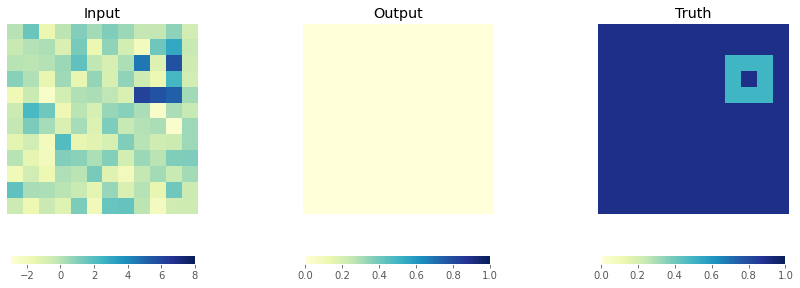

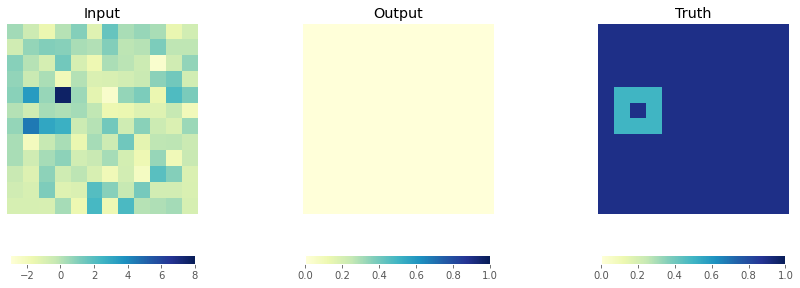

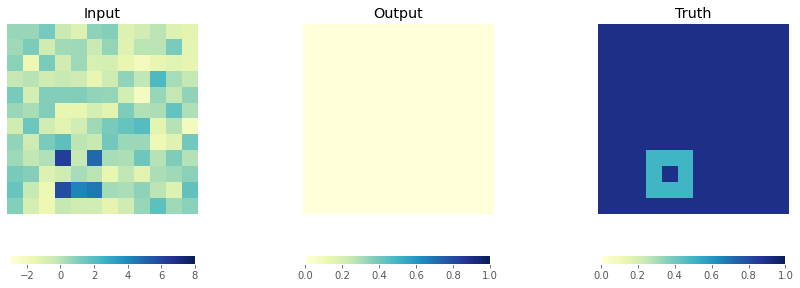

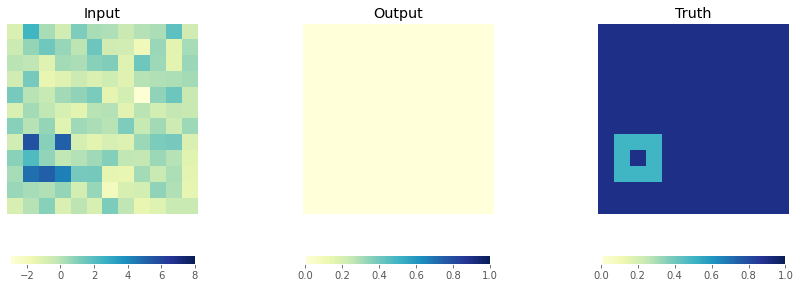

In [21]:
# Display a few samples
for k in [0,1,2,3]:
    displaySample(X,np.zeros(shape=X.shape),Y,k,A,B)

In [22]:
# Convert the data into tensors
X = torch.Tensor( X )
Y = torch.Tensor( Y )
print("Now X and Y are tensors")
print(X.shape)
print(Y.shape)
# scipy.io loads .mat files in as a dictionary of np arrays so this is an easy 
# way to convert those arrays into tensors.

Now X and Y are tensors
torch.Size([500, 1, 12, 12])
torch.Size([500, 1, 12, 12])


In [23]:
# We can still slice tensors to split data into training and validation sets
train_size = 400
X_tr = X[           :train_size, :, :, : ]
X_va = X[ train_size:          , :, :, : ]
Y_tr = Y[           :train_size, :, :, : ]
Y_va = Y[ train_size:          , :, :, : ]

# Display shapes
print("The shape of X_tr:", X_tr.shape)
print("The shape of X_va:", X_va.shape)
print("The shape of Y_tr:", Y_tr.shape)
print("The shape of Y_va:", Y_va.shape)

The shape of X_tr: torch.Size([400, 1, 12, 12])
The shape of X_va: torch.Size([100, 1, 12, 12])
The shape of Y_tr: torch.Size([400, 1, 12, 12])
The shape of Y_va: torch.Size([100, 1, 12, 12])


# Build a Model

Building a model is little bit different in PyTorch. I know how to do it but not necessarily why. There is also a tool called nn.ModuleList which allows you to pass the number of layers as input which could be helpful if you want to change the depth of the Unet as you go. I wasn't sure exactly how to implement here though

The layers we want are as follows:


```
1 - Convolution(        1 in,   CHAN out, 3x3 kernel, 1x1 stride, padding, relu )
2 - Max Pool(                             2x2 kernel, 2x2 stride )
3 - Convolution(     CHAN in, 2xCHAN out, 3x3 kernel, 1x1 stride, padding, relu )
4 - TransposeConv( 2xCHAN in,   CHAN out, 2x2 kernel, 2x2 stride,          relu )
5 - Concatenate()
6 - Convolution(   2xCHAN in,   CHAN out, 3x3 kernel, 1x1 stride, padding, relu )
7 - Convolution(     CHAN in,      1 out, 3x3 kernel, 1x1 stride, padding, None )
```



In [24]:
# Define the model using a class
class MyUNetModel(torch.nn.Module):
    
    # Args you want to give to the model go with self
    def __init__(self, chan, kern ):
        # Not sure what super is but this line is the same with class name updated
        super(MyUNetModel, self).__init__()

        # feed the Args to the self
        self.chan = chan
        self.kern = kern

        # Define the layers here (Check docs for other inputs) (They don't need to be in order here)
        self.layer_1 = torch.nn.Conv2d(                    1,   self.chan, self.kern, stride=1, padding=1 )
        self.layer_2 = torch.nn.MaxPool2d(                                         2,        2            )
        self.layer_3 = torch.nn.Conv2d(            self.chan, 2*self.chan, self.kern, stride=1, padding=1 )
        self.layer_4 = torch.nn.ConvTranspose2d( 2*self.chan,   self.chan,         2, stride=2,           )
        self.layer_5 = torch.nn.Conv2d(          2*self.chan,   self.chan, self.kern, stride=1, padding=1 )
        self.layer_6 = torch.nn.Conv2d(            self.chan,           1, self.kern, stride=1, padding=1 )

    # Now define how the forward pass looks
    def forward(self, x): # Note that x is the input data
        x1 = torch.nn.functional.relu( self.layer_1(x) ) # Note how activation is implemented here
        x2 = self.layer_2(x1)
        x3 = torch.nn.functional.relu( self.layer_3(x2) )
        x4 = torch.nn.functional.relu( self.layer_4(x3) )
        x5 = torch.cat((x1,x4), dim=1)         # This doesn't need a layer defined above
        x6 = torch.nn.functional.relu( self.layer_5(x5) )
        y  = self.layer_6(x6)
        return y
print("MyUNetModel() is defined")

MyUNetModel() is defined


In [25]:
# Now we can build a model and print it
model = MyUNetModel(2,3)
# Note that the print function doesn't give a nice summary...
print(model)

MyUNetModel(
  (layer_1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer_3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_4): ConvTranspose2d(4, 2, kernel_size=(2, 2), stride=(2, 2))
  (layer_5): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer_6): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [26]:
# Define a function for a nice summary
# Note that the nested for loops allow for nested module lists to still be accepted
def modelSummary(model, names=True):
    all_rows = []
    all_weights = list(model.parameters())
    counter1 = 1
    counter2 = 1
    headers = ["Num.","Layer","Weights","Biases"]

    for c1_name, c1 in model.named_children():
        l = 0
        ll = 0
        for c2_name, c2 in c1.children():
            l+=1
            ll = 0
            for c3_name, c3 in c2.children():
                ll+=1
                lll = 0
                for c4_name, c4 in c3.childre():
                    lll+=1
                if lll == 0:
                    row = [counter1]
                    counter1+=1
                    row.append(c3_name) if names else row.append(c3)
                    if len(list(c3.parameters())) > 0:
                        row.append(all_weights[2*counter2-2].numel())
                        row.append(all_weights[2*counter2-1].numel())
                        all_rows.append(row)
                        counter2+=1
                    else:
                        row.append(0)
                        row.append(0)
                        all_rows.append(row)
            if ll == 0:
                row = [counter1]
                counter1+=1
                row.append(c2_name) if names else row.append(c2)
                if len(list(c2.parameters())) > 0:
                    row.append(all_weights[2*counter2-2].numel())
                    row.append(all_weights[2*counter2-1].numel())
                    all_rows.append(row)
                    counter2+=1
                else:
                    row.append(0)
                    row.append(0)
                    all_rows.append(row)
        if l+ll == 0 :
            row = [counter1]
            counter1+=1
            row.append(c1_name) if names else row.append(c1)
            if len(list(c1.parameters())) > 0:
                row.append(all_weights[2*counter2-2].numel())
                row.append(all_weights[2*counter2-1].numel())
                all_rows.append(row)
                counter2+=1
            else:
                row.append(0)
                row.append(0)
                all_rows.append(row)

    print(tabulate(all_rows, headers, tablefmt="grid"))

In [27]:
modelSummary(model)         # Second arg is True by default to give short layer names
modelSummary(model, False)  # Longer names give more information

+--------+---------+-----------+----------+
|   Num. | Layer   |   Weights |   Biases |
+========+=========+===========+==========+
|      1 | layer_1 |        18 |        2 |
+--------+---------+-----------+----------+
|      2 | layer_2 |         0 |        0 |
+--------+---------+-----------+----------+
|      3 | layer_3 |        72 |        4 |
+--------+---------+-----------+----------+
|      4 | layer_4 |        32 |        2 |
+--------+---------+-----------+----------+
|      5 | layer_5 |        72 |        2 |
+--------+---------+-----------+----------+
|      6 | layer_6 |        18 |        1 |
+--------+---------+-----------+----------+
+--------+----------------------------------------------------------------------------+-----------+----------+
|   Num. | Layer                                                                      |   Weights |   Biases |
+========+============================================================================+===========+==========+
|      

# Train the Model

PyTorch doesn't have a nice neat training function but this way it's actually easier to customize it to do whatever you want! The two functions immediately following, train() and valid(), will not need to be changed very much, if at all when starting different projects. They are both simple loops that iterate through the batches and use the model to predict.

In [28]:
# Make a function to train
def train(device, model, loader_X_tr, loader_Y_tr, optimizer):
    model.train() # Puts the model in training mode (ex. dropout will happen)

    loss_all = 0
    n = 0
    for x, y in zip(loader_X_tr, loader_Y_tr): # iterate through loaders
        n += x.shape[0]  # count the number of samples used for training
        x = x.to(device) # move x to the device
        y = y.to(device) # move y to the device
        optimizer.zero_grad() # clear the gradients from any previous pass
        y_pred = model(x)     # predict with the model
        loss = torch.nn.functional.mse_loss(y, y_pred) # Compute loss
        loss.backward() # compute gradients
        loss_all += x.shape[0]*loss.item() # Multiply the "batch mean loss" by number of samples in that batch
        optimizer.step() # Move the weights

    loss_all = loss_all/n # Divide total loss by number of samples to get mean
    return loss_all

In [29]:
# Make a function to evaluate
def valid(device, model, loader_X_va, loader_Y_va):
    model.eval() # Puts the model in eval mode (ex. dropout will NOT happen)

    loss_all = 0
    n = 0
    with torch.no_grad(): # Without doing anything about gradients to the model
        for x, y in zip(loader_X_va, loader_Y_va): # iterate through loaders
            n += x.shape[0]  # count the number of samples used for training
            x = x.to(device) # move x to the device
            y = y.to(device) # move y to the device
            y_pred = model(x) # predict with the model
            loss = torch.nn.functional.mse_loss(y, y_pred) # Compute loss
            loss_all += x.shape[0]*loss.item() # Multiply the "batch mean loss" by number of samples in that batch
    
    loss_all = loss_all/n # Divide total loss by number of samples to get mean
    return loss_all

In [30]:
# Define a few things for training
device = torch.device("cuda:0")
max_epoch  = 200
batch_size = 10
learning_rate = 0.01
Loss_tr    = []
Loss_va    = []
update_freq = 10

# We're going to use DataLoaders to feed data into the network in batches
X_tr_loader = torch.utils.data.DataLoader( X_tr, batch_size=batch_size )
X_va_loader = torch.utils.data.DataLoader( X_va, batch_size=batch_size )
Y_tr_loader = torch.utils.data.DataLoader( Y_tr, batch_size=batch_size )
Y_va_loader = torch.utils.data.DataLoader( Y_va, batch_size=batch_size )

# Make a model and put on the device. Also define an optimizer
model = MyUNetModel(2,3).to(device)
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate ) # Tell it the parameters to optimize

# Start main training loop
start_time = time.time()
for epoch in range(1,max_epoch): # For each epoch

    loss_tr = train( device, model, X_tr_loader, Y_tr_loader, optimizer ) # train one epoch
    loss_va = valid( device, model, X_va_loader, Y_va_loader ) # validate one epoch

    # Store the loss values
    Loss_tr.append(loss_tr)
    Loss_va.append(loss_va)

    if epoch % update_freq == 0:
        elapsed = time.time() - start_time
        hrs = int(elapsed//3600)
        mins = int((elapsed-3600*hrs)//60)
        sec = int((elapsed-3600*hrs-60*mins)//1)
        print('({:02d}:{:02d}:{:02d}) Epoch {:3d} | Training Loss {:.4f} | Validation Loss {:.4f}'
        .format( hrs, mins, sec, epoch, loss_tr, loss_va ))
print("Done training!")

(00:00:01) Epoch  10 | Training Loss 0.0031 | Validation Loss 0.0028
(00:00:02) Epoch  20 | Training Loss 0.0018 | Validation Loss 0.0017
(00:00:04) Epoch  30 | Training Loss 0.0014 | Validation Loss 0.0013
(00:00:05) Epoch  40 | Training Loss 0.0010 | Validation Loss 0.0009
(00:00:06) Epoch  50 | Training Loss 0.0009 | Validation Loss 0.0008
(00:00:08) Epoch  60 | Training Loss 0.0008 | Validation Loss 0.0007
(00:00:09) Epoch  70 | Training Loss 0.0007 | Validation Loss 0.0007
(00:00:10) Epoch  80 | Training Loss 0.0007 | Validation Loss 0.0006
(00:00:12) Epoch  90 | Training Loss 0.0007 | Validation Loss 0.0006
(00:00:13) Epoch 100 | Training Loss 0.0006 | Validation Loss 0.0006
(00:00:14) Epoch 110 | Training Loss 0.0006 | Validation Loss 0.0006
(00:00:16) Epoch 120 | Training Loss 0.0006 | Validation Loss 0.0006
(00:00:17) Epoch 130 | Training Loss 0.0006 | Validation Loss 0.0005
(00:00:18) Epoch 140 | Training Loss 0.0006 | Validation Loss 0.0005
(00:00:20) Epoch 150 | Training Lo

# Train the Model (Advanced)

We can do early stopping or print pictures just like in TensorFlow. We just need to code it up instead of using the checkpoint framework

(00:00:01) Epoch  10 | Training Loss 0.0024 | Validation Loss 0.0022


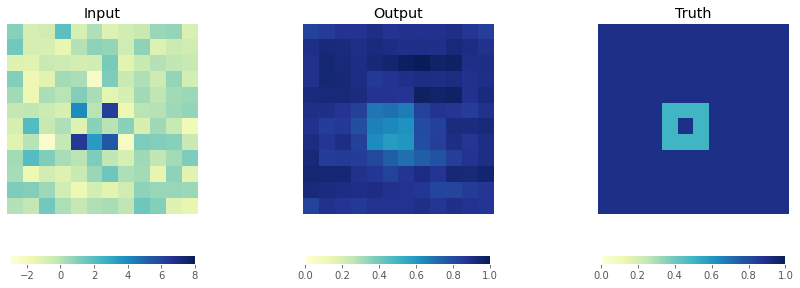

(00:00:02) Epoch  20 | Training Loss 0.0011 | Validation Loss 0.0011


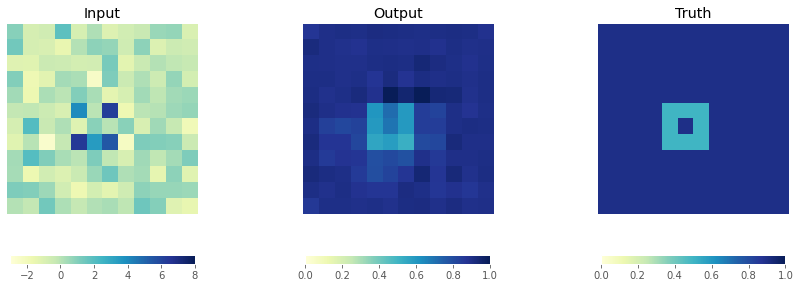

(00:00:04) Epoch  30 | Training Loss 0.0006 | Validation Loss 0.0006


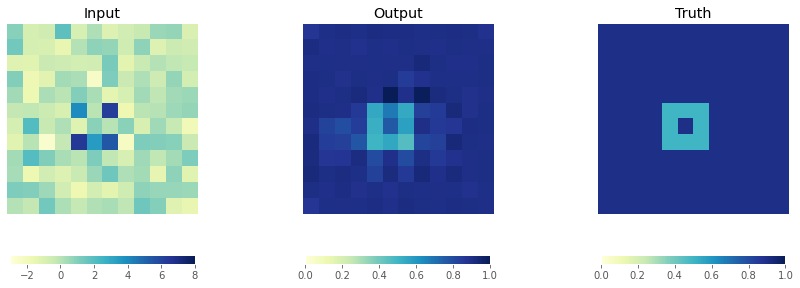

(00:00:05) Epoch  40 | Training Loss 0.0005 | Validation Loss 0.0004


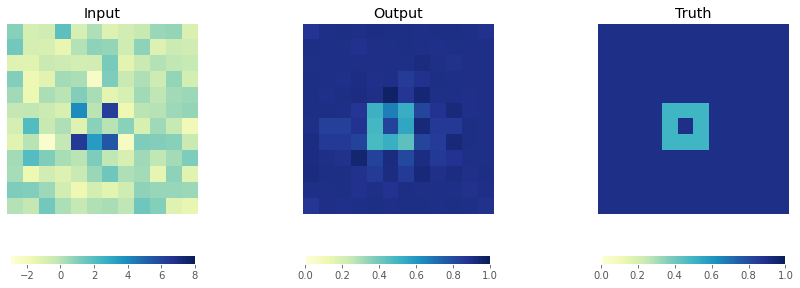

(00:00:07) Epoch  50 | Training Loss 0.0004 | Validation Loss 0.0003


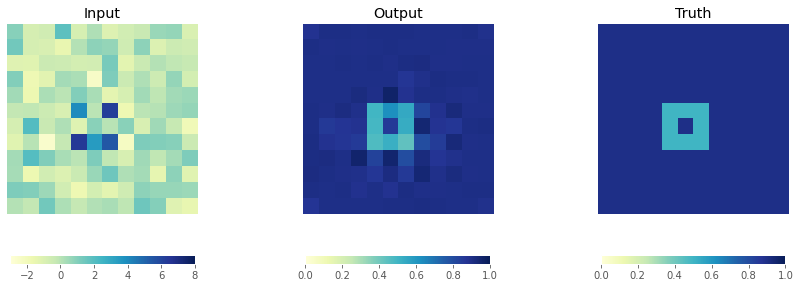

(00:00:09) Epoch  60 | Training Loss 0.0003 | Validation Loss 0.0003


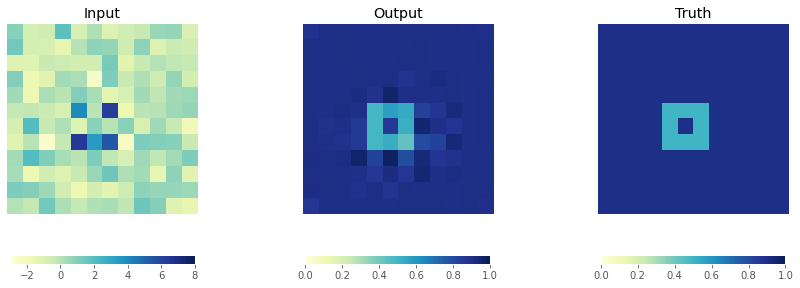

(00:00:10) Epoch  70 | Training Loss 0.0003 | Validation Loss 0.0003


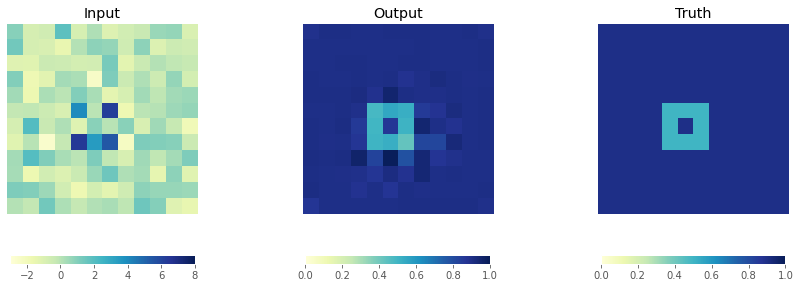

(00:00:12) Epoch  80 | Training Loss 0.0003 | Validation Loss 0.0002


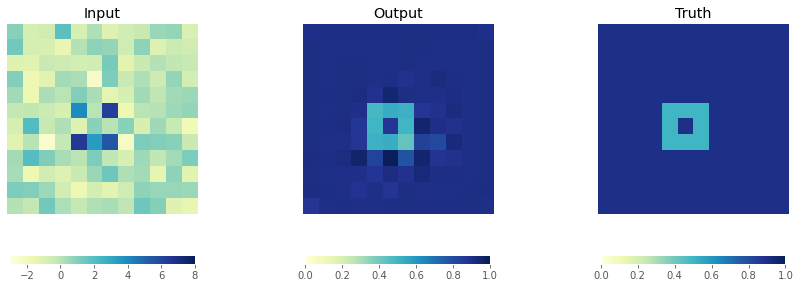

(00:00:13) Epoch  90 | Training Loss 0.0003 | Validation Loss 0.0002


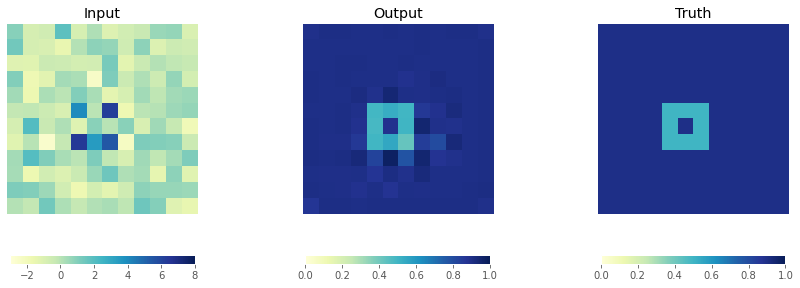

(00:00:15) Epoch 100 | Training Loss 0.0002 | Validation Loss 0.0002


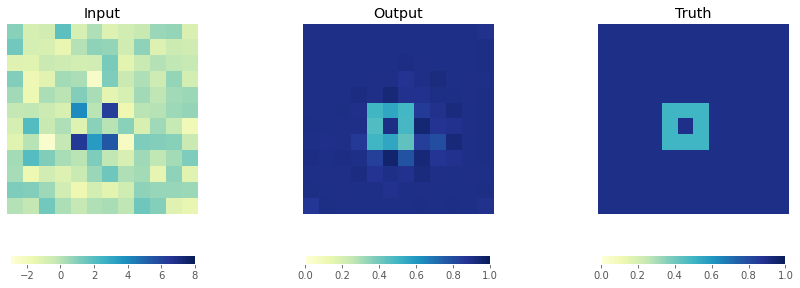

(00:00:17) Epoch 110 | Training Loss 0.0002 | Validation Loss 0.0002


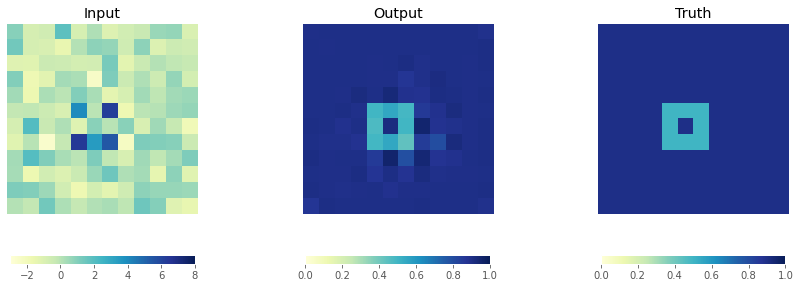

(00:00:18) Epoch 120 | Training Loss 0.0002 | Validation Loss 0.0002


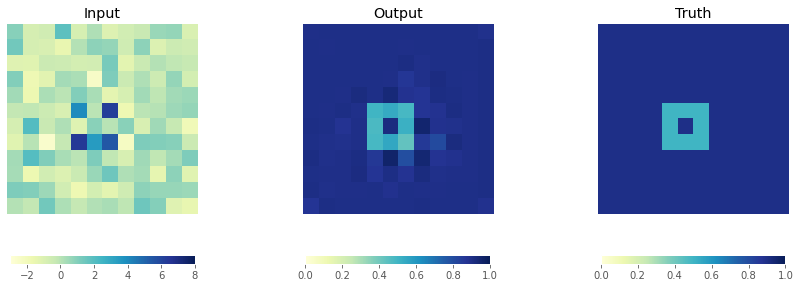

(00:00:20) Epoch 130 | Training Loss 0.0002 | Validation Loss 0.0002


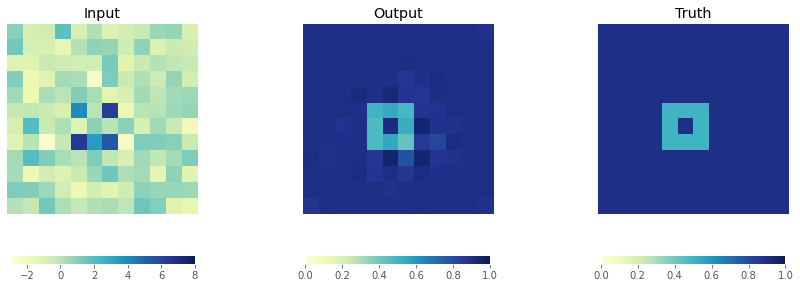

(00:00:21) Epoch 140 | Training Loss 0.0002 | Validation Loss 0.0002


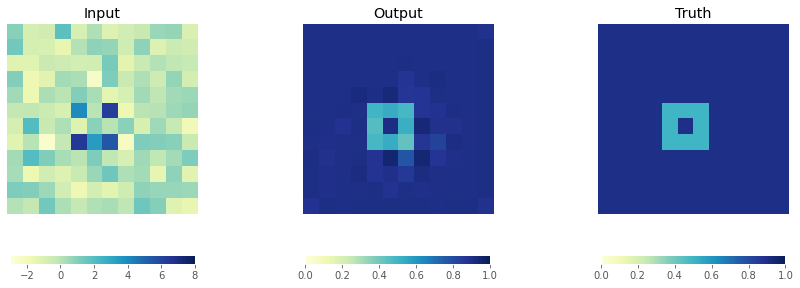

(00:00:23) Epoch 150 | Training Loss 0.0002 | Validation Loss 0.0002


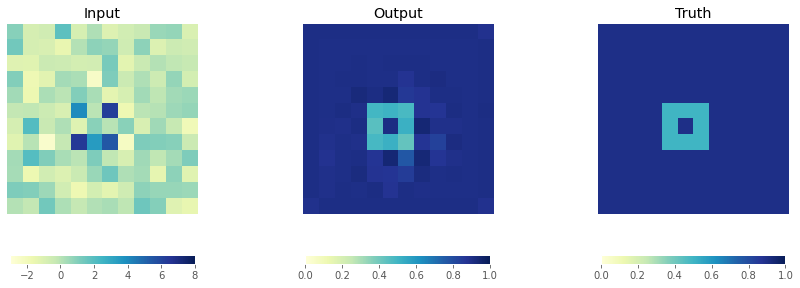

(00:00:24) Epoch 160 | Training Loss 0.0002 | Validation Loss 0.0002


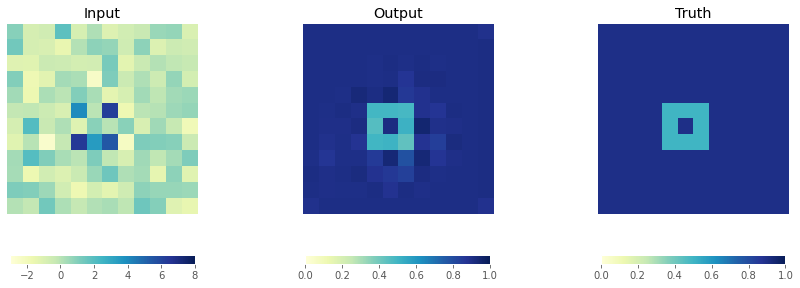

(00:00:26) Epoch 170 | Training Loss 0.0002 | Validation Loss 0.0001


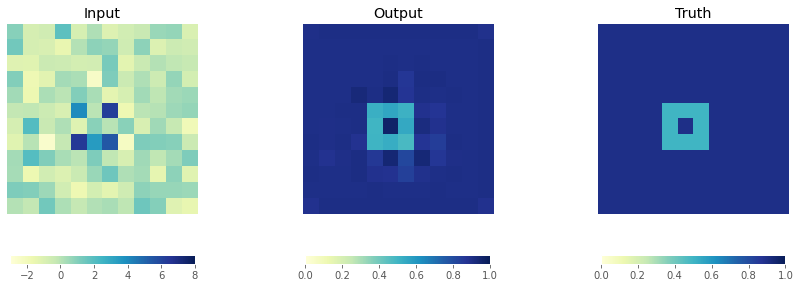

(00:00:28) Epoch 180 | Training Loss 0.0000 | Validation Loss 0.0000


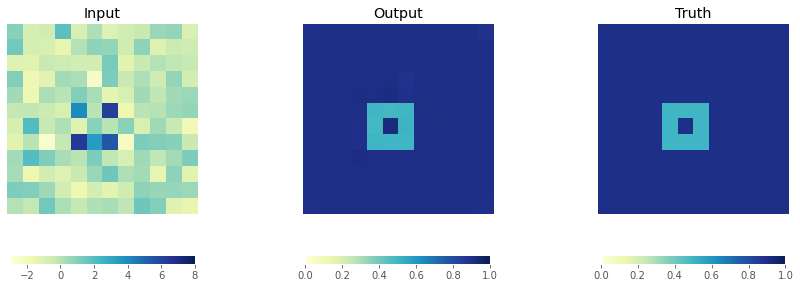

(00:00:29) Epoch 190 | Training Loss 0.0000 | Validation Loss 0.0000


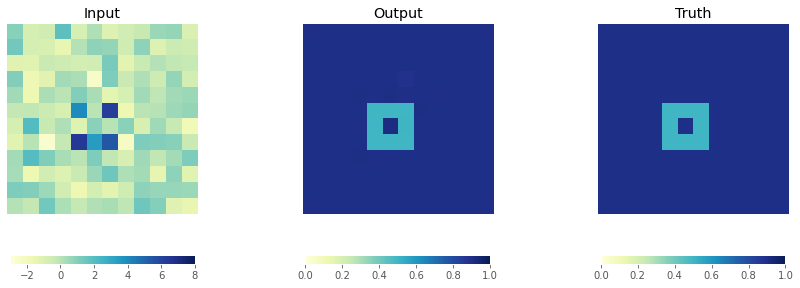

Done training!


In [33]:
# Define a few things for training
device = torch.device("cuda:0")
max_epoch  = 200
batch_size = 10
learning_rate = 0.01
Loss_tr    = []
Loss_va    = []
update_freq = 10
print_pics = True
patience = 10

# We're going to use DataLoaders to feed data into the network in batches
X_tr_loader = torch.utils.data.DataLoader( X_tr, batch_size=batch_size )
X_va_loader = torch.utils.data.DataLoader( X_va, batch_size=batch_size )
Y_tr_loader = torch.utils.data.DataLoader( Y_tr, batch_size=batch_size )
Y_va_loader = torch.utils.data.DataLoader( Y_va, batch_size=batch_size )

# Make a model and put on the device. Also define an optimizer
model = MyUNetModel(2,3).to(device)
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate ) # Tell it the parameters to optimize

# Start main training loop
start_time = time.time()
loss_va_min = 9999
pat = patience
for epoch in range(1,max_epoch): # For each epoch

    loss_tr = train( device, model, X_tr_loader, Y_tr_loader, optimizer ) # train one epoch
    loss_va = valid( device, model, X_va_loader, Y_va_loader ) # validate one epoch

    # Store the loss values
    Loss_tr.append(loss_tr)
    Loss_va.append(loss_va)

    if epoch % update_freq == 0:
        elapsed = time.time() - start_time
        hrs = int(elapsed//3600)
        mins = int((elapsed-3600*hrs)//60)
        sec = int((elapsed-3600*hrs-60*mins)//1)
        print('({:02d}:{:02d}:{:02d}) Epoch {:3d} | Training Loss {:.4f} | Validation Loss {:.4f}'
        .format( hrs, mins, sec, epoch, loss_tr, loss_va ))

        # Print some pictures every so often....
        if print_pics:
            model.eval() # Make sure the model is eval mode
            with torch.no_grad(): # Don't change any gradient info
                Y_va_pred = model(X_va.to(device)).to('cpu') # Move x to device, predict, and move prediction back to cpu
                for k in [2]:
                    displaySample(X_va.numpy(),Y_va_pred.numpy(),Y_va.numpy(),k,A,B)
                    # X_va, etc. are all tensors. Change to numpys before plotting
                    # Only tensors on cpu can be converted back to numpy arrays


    # Check for early stopping
    if loss_va <= loss_va_min:
        loss_va_min = loss_va # update minimum loss
        best_model = copy.deepcopy(model) # make an actual copy of the model
        pat = patience # reset patience
        epoch_best = epoch
    else:
        pat -= 1
        if pat == 0: # If we run out of patience
            for model_w, best_w in zip(model.parameters(), best_model.parameters()):
                model_w.data = best_w.data # Loop through all parameters and set to best set
            print("Training stopped early")
            print("Best epoch was", epoch_best)
            break # break for loop
print("Done training!")

# Finally, save the model from cpu
#model = model.to('cpu') # Move the model to cpu
#PATH = 'model.pt'       # Define a save path
#torch.save( model.state_dict(), PATH ) # Save the model's state_dict(). This has structure, parameters, and gradient information in it